# Breast Cancer Project
# Lymph Node Metastasis Prediction Using miRNA Expression Data
# Improved Deep Learning Pipeline with TensorFlow/Keras

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import pickle
import os

In [2]:

np.random.seed(42)
tf.random.set_seed(42)

## Import Functions

In [3]:
def read_object(obj_path):
    with open(obj_path, 'rb') as input:
        return pickle.load(input)

def save_object(obj, dir_path, file_name, file_extension='pkl', create_dir=True):
    if create_dir:
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
    name = os.path.normpath(os.path.join(dir_path, file_name+'.'+file_extension))
    with open(name, 'wb') as output:  # overwrites any existing file
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        return name

## Loading and Preparing Data

### miRNA Data

In [4]:
dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/Data/'
file_name = 'Human__TCGA_BRCA__BDGSC__miRNASeq__HS_miR__01_28_2016__BI__Gene__Firehose_RPKM_log2 (HiSeq_Gene level).cct'
miRNA_data = pd.read_table(dir_path + file_name, sep='\t', low_memory=False)
miRNA_data

,attrib_name,TCGA.3C.AAAU,TCGA.3C.AALI,TCGA.3C.AALJ,TCGA.3C.AALK,TCGA.4H.AAAK,TCGA.5L.AAT0,TCGA.5L.AAT1,TCGA.5T.A9QA,TCGA.A1.A0SB,...,TCGA.UL.AAZ6,TCGA.UU.A93S,TCGA.V7.A7HQ,TCGA.W8.A86G,TCGA.WT.AB41,TCGA.WT.AB44,TCGA.XX.A899,TCGA.XX.A89A,TCGA.Z7.A8R5,TCGA.Z7.A8R6
0,hsa-let-7a-1,13.1299,12.9183,13.0122,13.1449,13.4118,13.3164,13.4454,13.7280,13.6016,...,11.3871,12.8293,13.0703,13.7166,13.0353,13.3759,14.0362,13.6797,12.9623,13.3498
1,hsa-let-7a-2,14.1180,13.9224,14.0101,14.1418,14.4136,14.3110,14.4486,14.7146,14.6088,...,12.3949,13.8227,14.0704,14.7092,14.0367,14.3667,15.0364,14.6849,13.9664,14.3500
2,hsa-let-7a-3,13.1479,12.9134,13.0287,13.1514,13.4206,13.3273,13.4469,13.7370,13.6132,...,11.4324,12.8242,13.0611,13.7177,13.0530,13.3700,14.0434,13.6916,12.9851,13.3786
3,hsa-let-7b,14.5952,14.5127,13.4197,14.6673,14.4386,14.5766,14.6112,15.0988,16.5058,...,11.3976,13.5017,13.6050,15.2094,13.9086,14.5141,14.3396,14.1983,14.3207,14.1173
4,hsa-let-7c,8.4191,9.6483,9.3147,11.5119,11.6944,11.1391,11.2850,9.2000,13.3923,...,7.3776,10.8293,10.6679,12.4698,11.2441,11.9267,12.3620,12.6844,11.9806,10.3791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,hsa-mir-95,2.3574,1.1753,1.4031,1.4538,0.8567,1.4006,1.2028,2.8734,1.6279,...,0.8669,1.0416,2.4242,1.1042,2.0449,1.1489,1.7304,0.9498,1.4097,1.9057
819,hsa-mir-96,6.9187,5.9366,6.6184,6.2011,4.3887,6.5431,4.8486,5.7052,5.6049,...,6.4282,4.7626,5.5974,6.0759,5.8115,6.3365,4.1400,5.4236,5.8132,5.5220
820,hsa-mir-98,5.7812,6.4437,6.8905,5.4122,5.1449,5.3830,5.9911,5.3635,6.0218,...,6.4690,5.5098,6.1216,5.1681,6.0045,5.8735,5.8666,5.7870,5.7553,6.3427
821,hsa-mir-99a,7.0356,7.8914,7.5882,10.0330,10.0795,9.3659,9.3093,6.9476,12.0124,...,5.4539,9.3879,9.2302,10.6873,9.7652,10.1058,10.9073,10.3566,10.1318,8.8803


### Clinical Data

In [5]:
dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/Data/'
file_name = 'Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi'
clinical_data = pd.read_table(dir_path + file_name, sep='\t', low_memory=False)
clinical_data

,attrib_name,TCGA.5L.AAT0,TCGA.5L.AAT1,TCGA.A1.A0SP,TCGA.A2.A04V,TCGA.A2.A04Y,TCGA.A2.A0CQ,TCGA.A2.A1G4,TCGA.A2.A25A,TCGA.A7.A0CD,...,TCGA.S3.AA11,TCGA.S3.AA14,TCGA.S3.AA15,TCGA.UL.AAZ6,TCGA.UU.A93S,TCGA.V7.A7HQ,TCGA.WT.AB44,TCGA.XX.A899,TCGA.XX.A89A,TCGA.Z7.A8R6
0,years_to_birth,42,63,40,39,53,62,71,44,66,...,67,47,51,73,63,75,NaN,46,68,46
1,Tumor_purity,0.6501,0.5553,0.6913,0.8341,0.7318,0.7701,0.8879,0.595,0.8525,...,0.7638,0.7492,0.5387,0.8031,0.8339,0.7774,0.7493,0.6069,0.6067,0.8143
2,pathologic_stage,stageii,stageiv,stageii,stageii,stageii,stagei,stageiii,stageii,stagei,...,stageii,stagei,stageii,stageii,stageiv,stageiii,stagei,stageiii,stageii,stagei
3,pathology_T_stage,t2,t2,t2,t2,t2,t1,t3,t2,t1,...,t2,t1,t2,t2,t4,t1,t1,t1,t3,t1
4,pathology_N_stage,n0,n0,n0,n0,n1,n0,n1,n0,n0,...,n0,n0,n1,n0,n3,n2,n0,n2,n0,n0
5,pathology_M_stage,m0,m1,m0,m0,m0,m0,m0,m0,m0,...,m0,m0,m0,NaN,m1,m0,NaN,NaN,NaN,m0
6,histological_type,infiltratinglobularcarcinoma,infiltratinglobularcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratinglobularcarcinoma,infiltratingductalcarcinoma,...,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratingductalcarcinoma,infiltratinglobularcarcinoma,infiltratinglobularcarcinoma,infiltratinglobularcarcinoma,infiltratinglobularcarcinoma
7,number_of_lymph_nodes,0,0,0,0,1,0,2,0,0,...,0,0,2,NaN,NaN,5,0,5,0,0
8,PAM50,NaN,NaN,Basal,LumA,LumB,LumA,LumB,NaN,LumA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ER.Status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## preprocessing

In [6]:
def get_row(data, feature_name):
    matches = data[data.iloc[:, 0] == feature_name]
    if matches.empty: return None
    return data.iloc[matches.index[0], 1:]

t_stage_row = get_row(clinical_data, 'pathology_T_stage').str.lower().str.strip()
n_stage_row = get_row(clinical_data, 'pathology_N_stage').str.lower().str.strip()
age_row = get_row(clinical_data, 'years_to_birth')

samples = []

id_sample = [x.strip() for x in miRNA_data.columns[1:].tolist()]

for i, raw_id in enumerate(miRNA_data.columns[1:]):
    sample_id = raw_id.strip()
    
    if (sample_id in n_stage_row.index) and (sample_id in t_stage_row.index):
        
        
        n_val = n_stage_row[sample_id]
        if pd.isna(n_val) or not isinstance(n_val, str): continue
        
        if n_val == 'n0': target = 0
        elif n_val.startswith('n'): target = 1 
        else: continue

        
        t_str = str(t_stage_row[sample_id])
        if 't1' in t_str: t_score = 1
        elif 't2' in t_str: t_score = 2
        elif 't3' in t_str: t_score = 3
        elif 't4' in t_str: t_score = 4
        else: t_score = np.nan 

        
        try: age_val = float(age_row[sample_id])
        except: age_val = np.nan

        
        mirna_vals = pd.to_numeric(miRNA_data.iloc[:, i+1], errors='coerce').values
        
        
        features = np.concatenate(([t_score, age_val], mirna_vals))
        
        samples.append({'features': features, 'target': target})

X = np.array([s['features'] for s in samples])
y = np.array([s['target'] for s in samples])

imputer = SimpleImputer(strategy='median') 
X = imputer.fit_transform(X)

print(f"Data Loaded. Samples: {X.shape[0]}, Features: {X.shape[1]}")


Data Loaded. Samples: 744, Features: 825


## feature selection

In [7]:
selector_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_model.fit(X, y)
fs = SelectFromModel(selector_model, max_features=80, threshold=-np.inf)
X_selected = fs.fit_transform(X, y)
X_selected.shape[1]

80

## Model Definition

In [17]:
def create_dnn_model(input_dim):
    model = Sequential()
    

    model.add(Input(shape=(input_dim,)))
    model.add(Dense(128, kernel_regularizer=l2(0.005))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4)) 
    
   
    model.add(Dense(64, kernel_regularizer=l2(0.005)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
   
    model.add(Dense(32, kernel_regularizer=l2(0.005)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
   
    model.add(Dense(1, activation='sigmoid'))
    
 
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model



## Training with Cross-Validation

Fold 1 ROC AUC: 0.7006
Fold 2 ROC AUC: 0.7380
Fold 3 ROC AUC: 0.6198
Fold 4 ROC AUC: 0.6961
Fold 5 ROC AUC: 0.6461


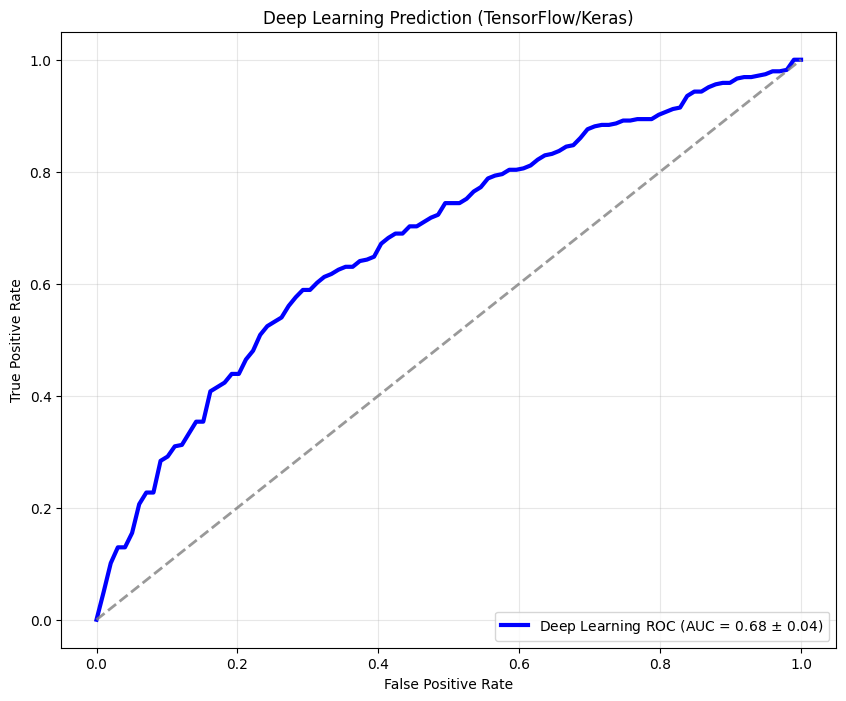


>>> Deep Learning Final AUC: 0.6801 <<<


In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 8))


all_train_true = []
all_train_pred = []

all_test_true = []
all_test_pred = []

fold_no = 1
for train_idx, test_idx in cv.split(X_selected, y):
    
    
    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    
    sm = SMOTE(random_state=42, k_neighbors=3)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    
    model = create_dnn_model(X_train.shape[1])

    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=0)

    
    history = model.fit(
        X_train_res, y_train_res,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    
    y_pred_prob = model.predict(X_test, verbose=0).ravel()

    
    train_pred_prob = model.predict(X_train, verbose=0).ravel()

    
    test_pred = (y_pred_prob >= 0.5).astype(int)
    train_pred = (train_pred_prob >= 0.5).astype(int)

    
    all_train_true.extend(y_train.tolist())
    all_train_pred.extend(train_pred.tolist())

    all_test_true.extend(y_test.tolist())
    all_test_pred.extend(test_pred.tolist())

    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    print(f"Fold {fold_no} ROC AUC: {roc_auc:.4f}")
    fold_no += 1
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='blue', label=r'Deep Learning ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=3)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', alpha=.8)
ax.set_title('Deep Learning Prediction (TensorFlow/Keras)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n>>> Deep Learning Final AUC: {mean_auc:.4f} <<<")



 FINAL TRAIN RESULTS 
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1428
           1       0.89      0.93      0.91      1548

    accuracy                           0.91      2976
   macro avg       0.91      0.90      0.91      2976
weighted avg       0.91      0.91      0.91      2976



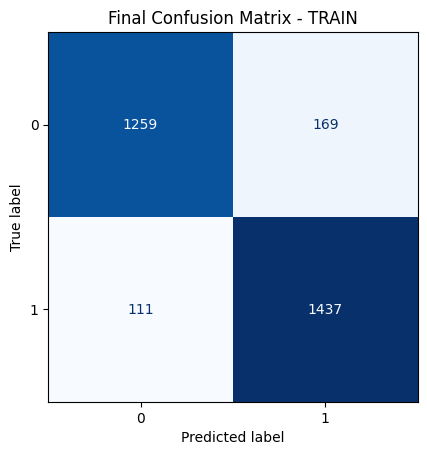


 FINAL TEST RESULTS 
              precision    recall  f1-score   support

           0       0.64      0.59      0.62       357
           1       0.65      0.69      0.67       387

    accuracy                           0.64       744
   macro avg       0.64      0.64      0.64       744
weighted avg       0.64      0.64      0.64       744



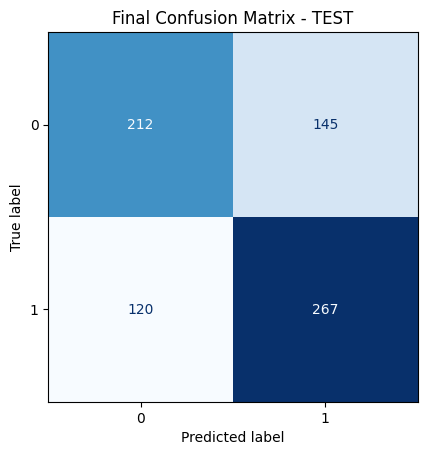

In [23]:
print("\n" + "="*60)
print(" FINAL TRAIN RESULTS ")
print("="*60)
print(classification_report(all_train_true, all_train_pred))
ConfusionMatrixDisplay.from_predictions(all_train_true, all_train_pred, cmap='Blues', colorbar=False)
plt.title("Final Confusion Matrix - TRAIN")
plt.show()

print("\n" + "="*60)
print(" FINAL TEST RESULTS ")
print("="*60)
print(classification_report(all_test_true, all_test_pred))
ConfusionMatrixDisplay.from_predictions(all_test_true, all_test_pred, cmap='Blues', colorbar=False)
plt.title("Final Confusion Matrix - TEST")
plt.show()

In [9]:
dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/improve_1/' 
file_name = 'X_selected'
save_object(X_selected, dir_path, file_name)

'F:\\internship\\Breast Cancer Project (Lymph Node Metastasis)(miRNA)\\improve_1\\X_selected.pkl'